In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

# print("Path to dataset files:", path)

100%|██████████| 25.7M/25.7M [00:06<00:00, 4.38MB/s]

Extracting files...


Path to dataset files: /home/quoc/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1


In [ ]:
import re
import nltk
import numpy as np
import pandas as pd

from numpy import array

from keras.layers import Flatten
from nltk.corpus import stopwords
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer

2025-04-25 15:32:49.748864: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 15:32:50.007973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745569970.113338   15507 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745569970.141166   15507 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745569970.355051   15507 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [9]:
data_path = "lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1/IMDB Dataset.csv"
movie_reviews = pd.read_csv(data_path)
# Check for null values

movie_reviews.isnull().values.any()

movie_reviews.shape

(50000, 2)

In [ ]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

<Axes: xlabel='sentiment', ylabel='count'>

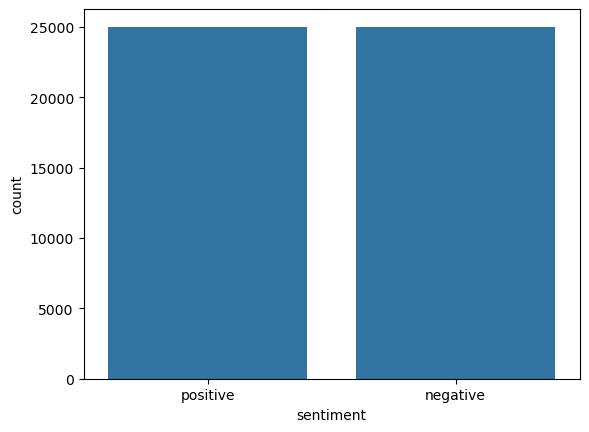

In [12]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews)

In [13]:
# Data Preprocessing
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence


TAG_RE = re.compile(r'<[^>]+>')


def remove_tags(text):
    return TAG_RE.sub('', text)

In [14]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [16]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

In [ ]:
# Convert label into digits
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x == "positive" else 0, y)))

In [18]:
# Divide dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [19]:
# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [20]:
# Set maximum size of each list to 100
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [21]:
# Use GloVe embeddings to create feature matrix
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open(
    'word_embeddings/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [22]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
# Design the model
from tensorflow.keras.layers import Conv1D
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[
                            embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [33]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     9,254,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,254,700 (35.30 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,254,700 (35.30 MB)

None


In [34]:
# Train the model
history = model.fit(X_train, y_train, batch_size=128,
                    epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6


250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - acc: 0.6992 - loss: 0.5690 - val_acc: 0.8191 - val_loss: 0.3963
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - acc: 0.8404 - loss: 0.3667 - val_acc: 0.8189 - val_loss: 0.3948
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - acc: 0.8686 - loss: 0.3160 - val_acc: 0.8381 - val_loss: 0.3557
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - acc: 0.8921 - loss: 0.2754 - val_acc: 0.8264 - val_loss: 0.3921
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 0.8948 - loss: 0.2585 - val_acc: 0.8434 - val_loss: 0.3541
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - acc: 0.9263 - loss: 0.2118 - val_acc: 0.8285 - val_loss: 0.3884


In [35]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8301 - loss: 0.3777


In [36]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.38150134682655334
Test Accuracy: 0.8321999907493591


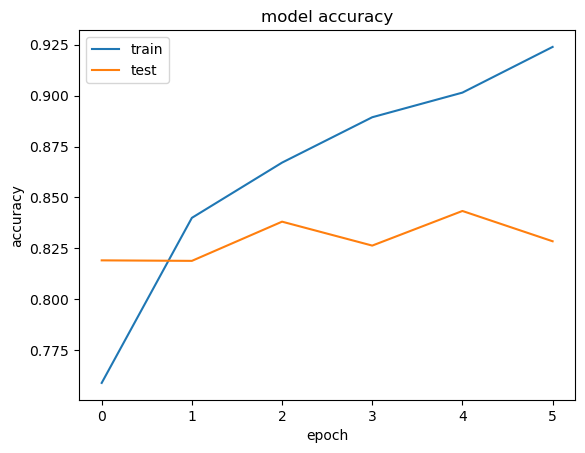

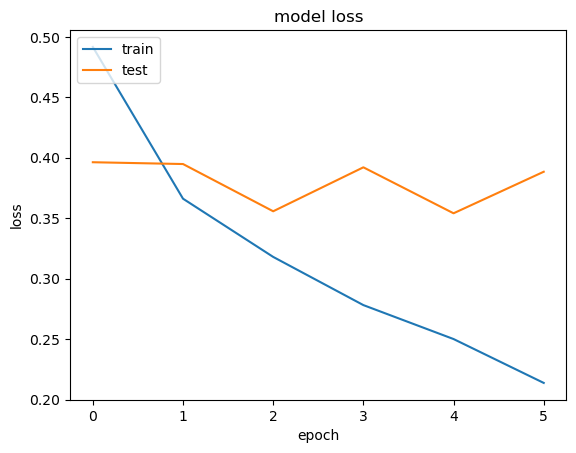

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Design the model RNN
from tensorflow.keras.layers import LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[
                            embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [40]:
print(model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │     9,254,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,254,700 (35.30 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,254,700 (35.30 MB)

None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128,
                    epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - acc: 0.6122 - loss: 0.6501 - val_acc: 0.7673 - val_loss: 0.4885
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - acc: 0.7682 - loss: 0.4805 - val_acc: 0.8101 - val_loss: 0.4214
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - acc: 0.8043 - loss: 0.4206 - val_acc: 0.8181 - val_loss: 0.3973
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 160ms/step - acc: 0.8302 - loss: 0.3805 - val_acc: 0.8380 - val_loss: 0.3685
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - acc: 0.8430 - loss: 0.3596 - val_acc: 0.8457 - val_loss: 0.3500
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - acc: 0.8485 - loss: 0.3367 - val_acc: 0.8508 - val_loss: 0.3381
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - acc: 0.8431 - loss: 0.3442


In [42]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.33874791860580444
Test Accuracy: 0.8482000231742859


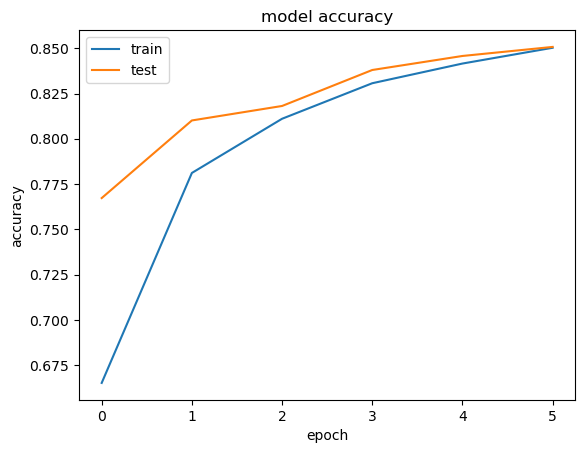

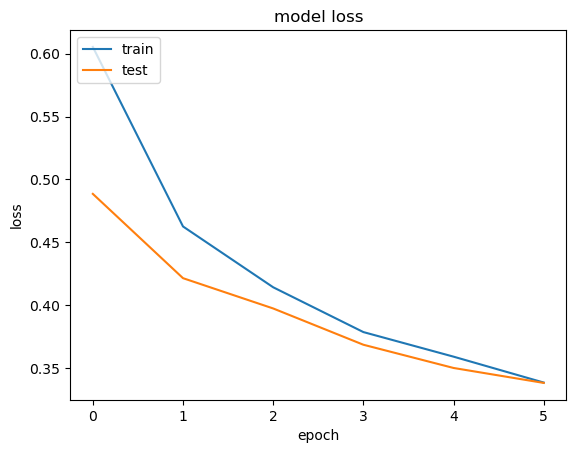

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
# Make predictions on single instance
instance = X[57]
print(instance)

I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned 


In [45]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


array([[0.28677836]], dtype=float32)